In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, plot_metrics, plot_metric, make_axis_great_again, plot_epochs, plot_lr
from post.utils import parse_epochs

In [3]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '12.05_20.05_near_complete_pipeline'

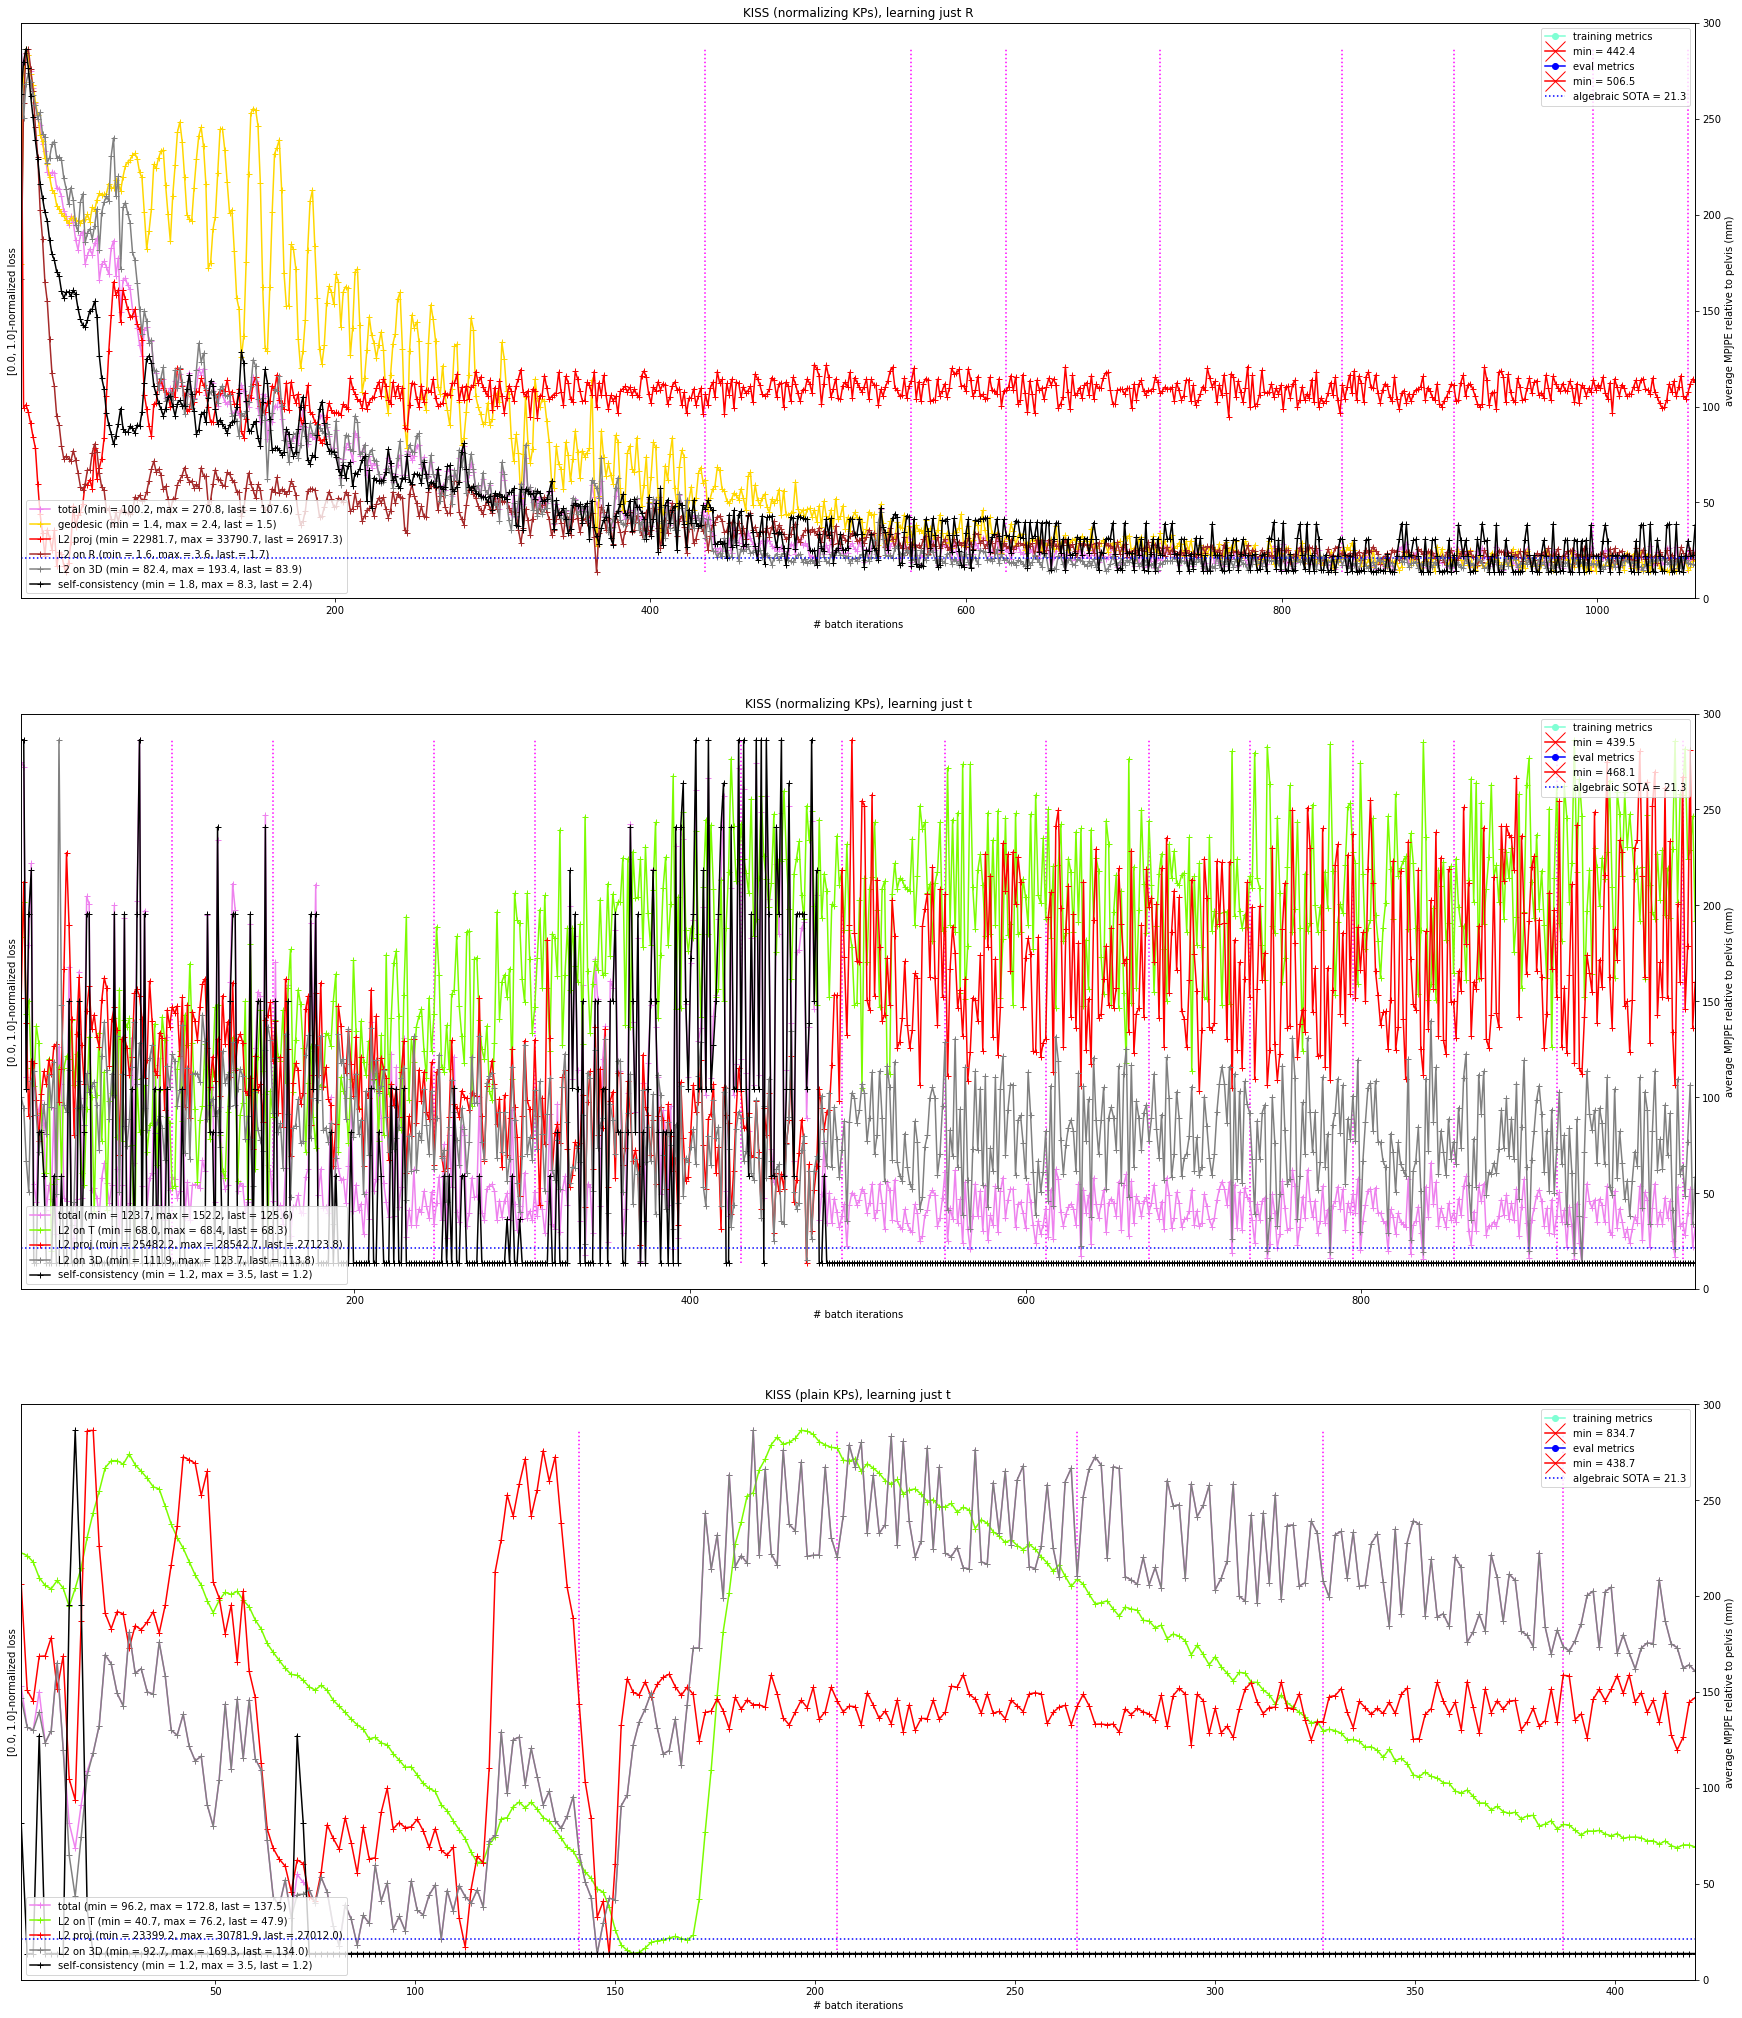

In [10]:
fig, axis = get_figa(3, 1, heigth=12, width=30)

training_batch_size = 8

job_id = '15726296'
exp_name, train_data_amount, _, epochs, lr_reductions = parse_job_log(current_milestone / '{}.out'.format(job_id))
batch_amount_per_epoch = train_data_amount / training_batch_size
xrange = np.arange(1, len(epochs) + 1) * batch_amount_per_epoch
metrics_ylim = [0, 3e2]

ax = axis.ravel()[0]
plot_epochs(
    ax, epochs, xrange,
    train_metric_ylim=metrics_ylim,
    eval_metric_ylim=metrics_ylim,
    normalize_loss=(0, 1),
    title='KISS (normalizing KPs), learning just R',
    metric_ylabel='average MPJPE relative to pelvis (mm)',
    xlabel='# batch iterations'
)
plot_lr(ax, lr_reductions, batch_amount_per_epoch)
make_axis_great_again(ax, xlim=xrange, ylim=None, hide_y=True)

job_id = '15726310'
exp_name, train_data_amount, _, epochs, lr_reductions = parse_job_log(current_milestone / '{}.out'.format(job_id))
batch_amount_per_epoch = train_data_amount / training_batch_size
xrange = np.arange(1, len(epochs) + 1) * batch_amount_per_epoch
metrics_ylim = [0, 3e2]

ax = axis.ravel()[1]
plot_epochs(
    ax, epochs, xrange,
    train_metric_ylim=metrics_ylim,
    eval_metric_ylim=metrics_ylim,
    normalize_loss=(0, 1),
    title='KISS (normalizing KPs), learning just t',
    metric_ylabel='average MPJPE relative to pelvis (mm)',
    xlabel='# batch iterations'
)
plot_lr(ax, lr_reductions, batch_amount_per_epoch)
make_axis_great_again(ax, xlim=xrange, ylim=None, hide_y=True)

job_id = '15772352'
exp_name, train_data_amount, _, epochs, lr_reductions = parse_job_log(current_milestone / '{}.out'.format(job_id))
batch_amount_per_epoch = train_data_amount / training_batch_size
xrange = np.arange(1, len(epochs) + 1) * batch_amount_per_epoch
metrics_ylim = [0, 3e2]

ax = axis.ravel()[2]
plot_epochs(
    ax, epochs, xrange,
    train_metric_ylim=metrics_ylim,
    eval_metric_ylim=metrics_ylim,
    normalize_loss=(0, 1),
    title='KISS (plain KPs), learning just t',
    metric_ylabel='average MPJPE relative to pelvis (mm)',
    xlabel='# batch iterations'
)
plot_lr(ax, lr_reductions, batch_amount_per_epoch)
make_axis_great_again(ax, xlim=xrange, ylim=None, hide_y=True)

# .png